In [94]:
import os
import wrds
import quandl
import zipfile
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import numpy as np 
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.cm as cm
import datetime as dt
pd.options.display.float_format = '{:.6f}'.format

## Helper Functions

In [95]:
BASE_DIR = Path(os.getcwd()).resolve()
DATA_DIR = BASE_DIR / "Data"
print(f'Base Directory: \n {BASE_DIR}')
print(f'Data Directory: \n {DATA_DIR}')

Base Directory: 
 /Users/kaleembukhari/Documents/Kaleem's Data/University of Chicago/GitHubRepositories/TE-Portfolio-Stress-Testing-Final-Project
Data Directory: 
 /Users/kaleembukhari/Documents/Kaleem's Data/University of Chicago/GitHubRepositories/TE-Portfolio-Stress-Testing-Final-Project/Data


In [378]:
def get_wrds_data(sql_query, start_date, end_date):

    try:
        db = wrds.Connection()
        formatted_query = sql_query.format(start_date=start_date, end_date=end_date)
        data = db.raw_sql(formatted_query)
        db.close()
        data['date'] = pd.to_datetime(data['date'])
        data.set_index('date', inplace = True)
        return data

    except Exception as e:
        print(f"Error retrieving data: {e}")
        return None

def fama_french_regression(factors, portfolio_excess_return):

    X = sm.add_constant(factors)
    Y = portfolio_excess_return
    model = sm.OLS(Y, X, missing='drop').fit()
    print(model.summary())
    results_df = pd.DataFrame({'Coefficient': model.params})
    return results_df

def compute_predictions_with_actual(parameters_df, factors_df, realized_returns, annualizing_factor):
    intercept = parameters_df.loc['const', 'Coefficient'] / annualizing_factor
    betas = parameters_df.drop('const')['Coefficient']
    
    predictions = intercept + factors_df @ betas

    prediction_df = pd.DataFrame({'Predicted Returns': predictions}, index=factors_df.index).dropna()
    actual_values = realized_returns
    actual_predict_df = pd.merge(prediction_df, actual_values, 
                                 how = 'inner', left_index = True, right_index = True)
    
    return actual_predict_df

    def macroeconomic_fama_french_regression(factors_df, macroecon_vars_df, annualizing_factor = 4):

        mev_reg_res_dict = {}

        features = macroecon_vars_df.copy()
        ff_factors = factors_df.copy()

        X = features
        X = sm.add_constant(X)

        for factor_ in ff_factors.columns:
            y = ff_factors[[factor_]]
            model = sm.OLS(y, X, missing = 'drop').fit()
            
            summary_ = model.summary
            params_df = pd.DataFrame(model.params, columns = ['Coefficient'])
            
            actual_vs_predicted_ff_df = compute_predictions_with_actual(params_df, features, y, annualizing_factor)
            
            mev_reg_res_dict[f'{factor_}'] = [summary_ , actual_vs_predicted_ff_df]
        
        return mev_reg_res_dict

## Section 5: Constructing a Generalized Factor Model to stress test portfolio performance

## 5.1. Model Development Plan

### Two-Step Approach
This framework is designed to evaluate the impact of macroeconomic variables on portfolio performance under both normal and stressed economic cycles. To achieve this, we develop two distinct multivariate regression models.

Including macroeconomic variables alongside Fama-French factors in a single model to assess portfolio performance is not ideal due to multicollinearity issues among independent variables. For instance, the Market Factor reflects overall market performance, which is inherently influenced by economic conditions. Correlated explanatory variables violate the assumptions of regression models, compromising robustness.

To address this, we adopt a two-step approach to build a generalized factor model for assessing portfolio performance. This approach will also be used for stress-testing portfolio performance.

### Mechanics of the Two-Step Model Approach:
- **Model 1 - Portfolio Returns Factor Model**
Construct a factor model using the Fama-French factors, along with additional factors such as Momentum, Profitability, and Investment. This model assesses the impact of these factors on portfolio performance.

- **Model 2 - Factors vs Macroeconomic Varibales**: 
Develop a second model to analyze the relationship between macroeconomic variables and the individual factors used as independent variables in Model 1. Macroeconomic data will be transformed as necessary to ensure stationarity. Given that some macroeconomic variables have lagging effects on economic outcomes, appropriate lags will be incorporated to capture these dynamics effectively.

### Exposure Calculation
The portfolio return is regressed on factor exposures:

$$R_t - R_f = \alpha + \sum_{i} \beta_i \cdot F_{i,t} + \epsilon_t $$
Where:
- $R_t$: Portfolio return at time $t$
- $R_f$: Risk-free rate
- $\beta_i$: Portfolio exposure to factor $i$
- $F_{i,t}$: Return of factor $i$ at time $t$
- $\alpha$: Portfolio-specific alpha
- $\epsilon_t$: Residual term


Each factor is modeled as a function of macroeconomic variables:

$$F_{i,t} = \delta_i + \sum_{j} \gamma_{i,j} \cdot M_{j,t} + \eta_{i,t}$$
Where:
- $F_{i,t}$: Return of factor $i$ at time $t$
- $\delta_i$: Intercept term for factor $i$
- $\gamma_{i,j}$: Sensitivity of factor $i$ to macroeconomic variable $j$
- $M_{j,t}$: Macroeconomic variable $j$ at time $t$
- $\eta_{i,t}$: Residual term for factor $i$


The combined portfolio exposure to macroeconomic variables is given by:

$$\text{Portfolio Exposure} = \sum_{i} \beta_i \cdot \gamma_{i,j}$$
Where:
- $\beta_i$: Portfolio exposure to factor $i$ (from Step 1)
- $\gamma_{i,j}$: Sensitivity of factor $i$ to macroeconomic variable $j$ (from Step 2)


### Querying Fama-French Factors from WRDS
- <b> Note:</b> We have used the following query to download data from WRDS directly instead of using the 'wrds_data.xlsx' file. The query allowed us to download all 6 factors in a single run

In [297]:
# Fama French Sql Query
fama_french_sql_query = """
            SELECT date, 
                   mktrf AS MKT, 
                   smb AS SMB, 
                   hml AS HML,
                   rmw AS PROFT,
                   cma AS INVST,
                   rf AS RFR,
                   umd AS MMNTM
            FROM ff_all.fivefactors_monthly
            WHERE date BETWEEN '{start_date}' AND '{end_date}'
            ORDER BY date;
            """

In [435]:
start_date = '1991-12-01'
end_date = '2024-12-31'
ff_6_factors = get_wrds_data(fama_french_sql_query, start_date, end_date)

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [436]:
ff_6_factors.head()

,mkt,smb,hml,proft,invst,rfr,mmntm
date,,,,,,,
1991-12-01,0.108400,-0.024000,-0.041700,0.035500,-0.031200,0.003800,0.081900
1992-01-01,-0.005900,0.091800,0.047100,-0.013200,0.032000,0.003400,-0.024900
1992-02-01,0.010900,0.013300,0.064700,0.000800,0.021900,0.002800,-0.005300
1992-03-01,-0.026600,-0.009300,0.035600,-0.000100,0.019500,0.003400,-0.002900
1992-04-01,0.010700,-0.057000,0.043400,0.016900,0.022300,0.003200,-0.025800


### Saving Fama-French 5 Factors plus Momentum Data
- Data type: Returns
- Frequency: Monthly resample to Quarterly

In [438]:
ff_6_factors = ff_6_factors.resample('QE').mean()
ff_6_factors.head()

,mkt,smb,hml,proft,invst,rfr,mmntm
date,,,,,,,
1991-12-31,0.108400,-0.024000,-0.041700,0.035500,-0.031200,0.003800,0.081900
1992-03-31,-0.007200,0.031933,0.049133,-0.004167,0.024467,0.003200,-0.011033
1992-06-30,-0.003233,-0.027400,0.029233,0.002300,0.012400,0.003067,-0.009833
1992-09-30,0.008600,-0.001867,-0.006400,0.022200,-0.010500,0.002767,0.008467
1992-12-31,0.022267,0.025633,-0.002367,0.000267,-0.005133,0.002467,0.022133


In [439]:
ff_6_factors_file = 'ff_6_factors.csv'
ff_6_factors.to_csv(DATA_DIR/ff_6_factors_file, index = True)

In [440]:
ff_6_factors.head()

,mkt,smb,hml,proft,invst,rfr,mmntm
date,,,,,,,
1991-12-31,0.108400,-0.024000,-0.041700,0.035500,-0.031200,0.003800,0.081900
1992-03-31,-0.007200,0.031933,0.049133,-0.004167,0.024467,0.003200,-0.011033
1992-06-30,-0.003233,-0.027400,0.029233,0.002300,0.012400,0.003067,-0.009833
1992-09-30,0.008600,-0.001867,-0.006400,0.022200,-0.010500,0.002767,0.008467
1992-12-31,0.022267,0.025633,-0.002367,0.000267,-0.005133,0.002467,0.022133


### Getting weighted portfolio returns

In [441]:
portfolio_file_ = 'final_portfolio_returns.csv'
prtf_rets = pd.read_csv(DATA_DIR/portfolio_file_)
prtf_rets['Date'] = pd.to_datetime(prtf_rets['Date'])
prtf_rets.set_index('Date', inplace = True)
prtf_rets = prtf_rets.resample('QE').mean()
prtf_rets.head()

,EW Portfolio Returns,EF Portfolio Returns
Date,,
1991-12-31,0.043899,0.021378
1992-03-31,-0.011370,0.006442
1992-06-30,-0.009997,-0.020122
1992-09-30,0.012729,0.010049
1992-12-31,0.031083,0.031738


In [442]:
analysis_start_date = prtf_rets.index.min()

In [443]:
prtfs_rets_ff_fctr = pd.merge(prtf_rets, ff_6_factors, 
                              how = 'inner', left_index = True, right_index = True)
prtfs_rets_ff_fctr['Weighted Portfolio Excess Returns'] = prtfs_rets_ff_fctr['EW Portfolio Returns'] - prtfs_rets_ff_fctr['rfr']
prtfs_rets_ff_fctr.head()

,EW Portfolio Returns,EF Portfolio Returns,mkt,smb,hml,proft,invst,rfr,mmntm,Weighted Portfolio Excess Returns
1991-12-31,0.043899,0.021378,0.108400,-0.024000,-0.041700,0.035500,-0.031200,0.003800,0.081900,0.040099
1992-03-31,-0.011370,0.006442,-0.007200,0.031933,0.049133,-0.004167,0.024467,0.003200,-0.011033,-0.014570
1992-06-30,-0.009997,-0.020122,-0.003233,-0.027400,0.029233,0.002300,0.012400,0.003067,-0.009833,-0.013064
1992-09-30,0.012729,0.010049,0.008600,-0.001867,-0.006400,0.022200,-0.010500,0.002767,0.008467,0.009963
1992-12-31,0.031083,0.031738,0.022267,0.025633,-0.002367,0.000267,-0.005133,0.002467,0.022133,0.028616


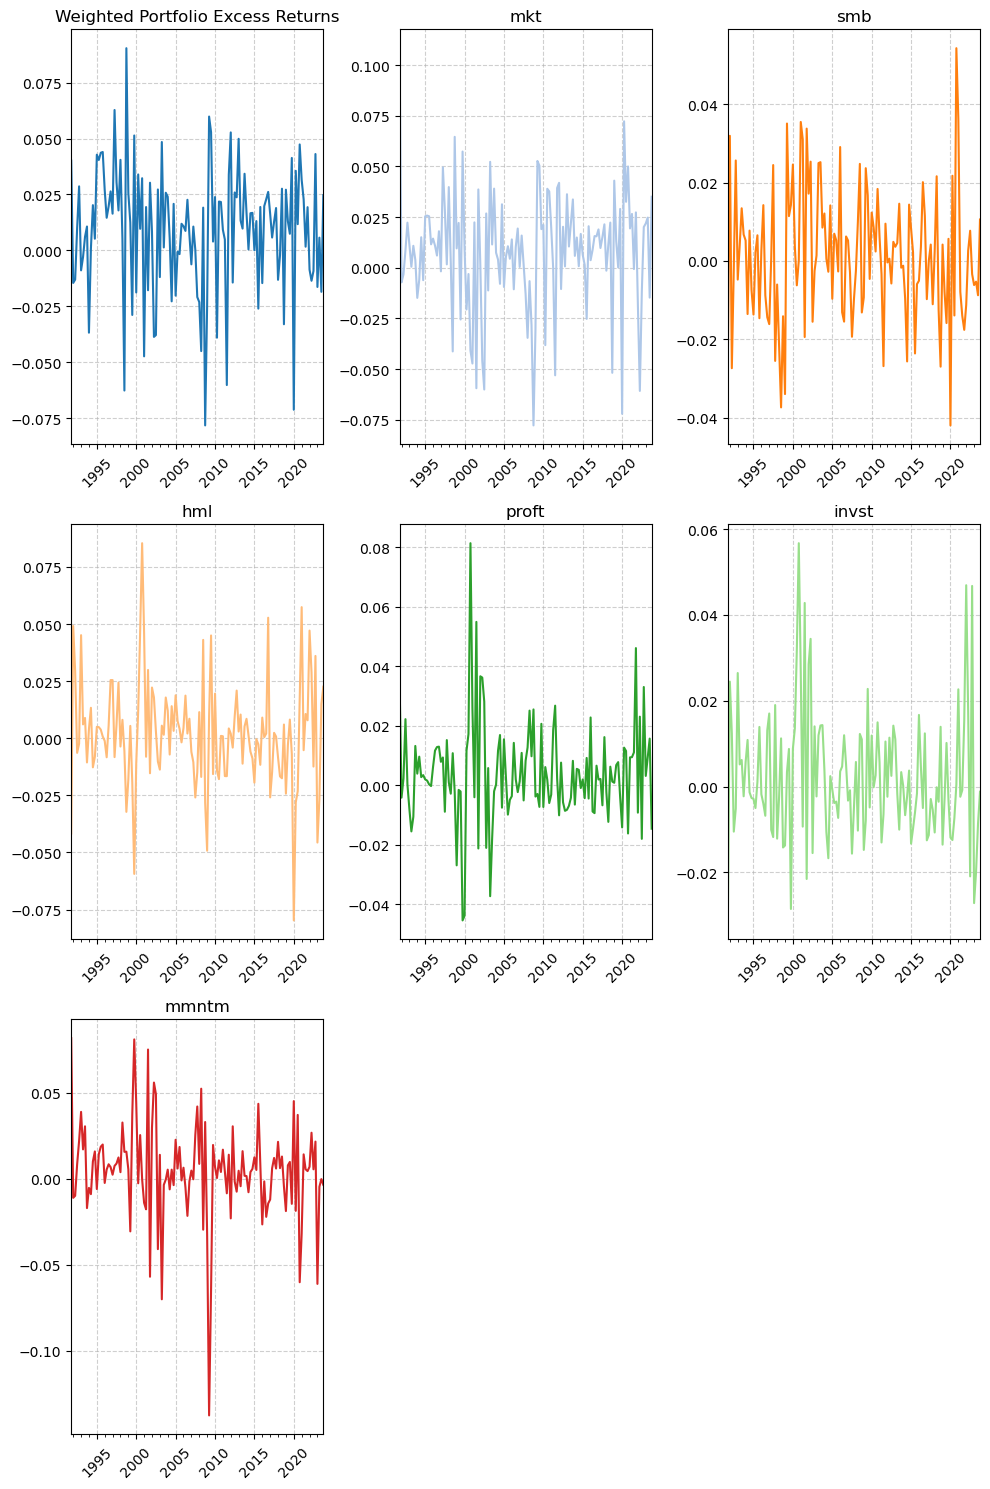

In [444]:
vars_to_plot = ['Weighted Portfolio Excess Returns', 'mkt', 'smb', 'hml', 'proft', 'invst', 'mmntm']
n_cols = 3
n_rows = (len(vars_to_plot) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))
axes = axes.flatten()

colors = cm.tab20.colors

for i, var_ in enumerate(vars_to_plot):
    color = colors[i % len(colors)]
    prtfs_rets_ff_fctr[var_].plot(ax=axes[i], color=color)
    axes[i].set_title(var_)
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axes[i].grid(True, linestyle='--', alpha=0.6)  # Add grid lines for readability

for j in range(len(vars_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Model 1: Portfolio Returns Prediction with Fama French Factors

### Following are the details of variables used

| **Category**        | **Variable**       | **Definition**|
|---------------------|--------------------|------------------------------|
|Dependent Variable   | Portfolio Excess Returns|
|Independent Variable   | MKT                |
|Independent Variable	  |SMB                 |
|Independent Variable	  |HML                 |
|Independent Variable	  |Profitability       |
|Independent Variable   |Investment          |
|Independent Variable	  |Momentum            |

In [445]:
factors_df = prtfs_rets_ff_fctr[['mkt', 'smb', 'hml', 'proft', 'invst', 'mmntm']]
prtf_exs_rets_df = prtfs_rets_ff_fctr[['Weighted Portfolio Excess Returns']]

### Regression Summary for Portfolio Returns

In [446]:
portfolio_returns_ff_factors_regression = fama_french_regression(factors_df, prtf_exs_rets_df)

                                    OLS Regression Results                                   
Dep. Variable:     Weighted Portfolio Excess Returns   R-squared:                       0.726
Model:                                           OLS   Adj. R-squared:                  0.713
Method:                                Least Squares   F-statistic:                     53.97
Date:                               Wed, 20 Nov 2024   Prob (F-statistic):           4.87e-32
Time:                                       13:21:20   Log-Likelihood:                 363.07
No. Observations:                                129   AIC:                            -712.1
Df Residuals:                                    122   BIC:                            -692.1
Df Model:                                          6                                         
Covariance Type:                           nonrobust                                         
                 coef    std err          t      P>|t|      

### In Sample Fitted Values/Predictions

In [447]:
portf_ff_regression_returns = compute_predictions_with_actual(portfolio_returns_ff_factors_regression, factors_df, prtf_exs_rets_df,4)
portf_ff_regression_returns.head()

,Predicted Returns,Weighted Portfolio Excess Returns
1991-12-31,0.072101,0.040099
1992-03-31,0.006546,-0.014570
1992-06-30,0.011411,-0.013064
1992-09-30,0.004140,0.009963
1992-12-31,0.012464,0.028616


## Plotting Portfolio Returns Predictions

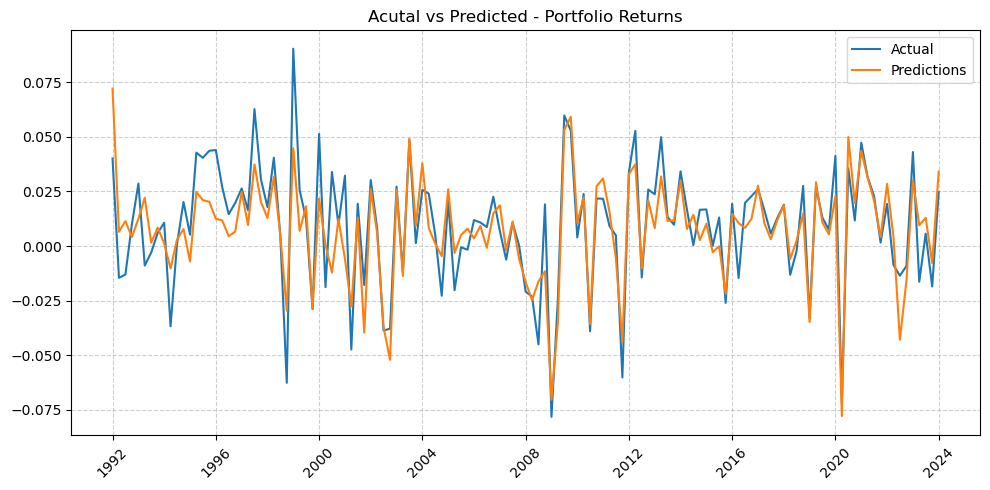

In [448]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

axes.plot(portf_ff_regression_returns.index, portf_ff_regression_returns['Weighted Portfolio Excess Returns']
          , label='Actual')
axes.plot(portf_ff_regression_returns.index, portf_ff_regression_returns['Predicted Returns'], label='Predictions')

axes.set_title("Acutal vs Predicted - Portfolio Returns")
axes.legend()
axes.grid(True, linestyle='--', alpha=0.6)
axes.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [449]:
portf_ff_regression_returns['Cumulative Actual Returns'] = (1 + portf_ff_regression_returns['Weighted Portfolio Excess Returns']).cumprod() - 1
portf_ff_regression_returns['Cumulative Predicted Returns'] = (1 + portf_ff_regression_returns['Predicted Returns']).cumprod() - 1

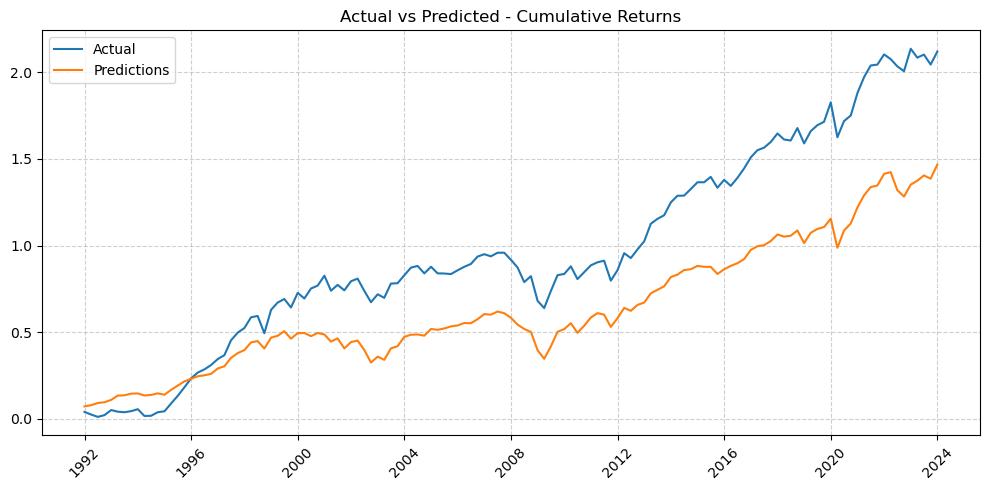

In [450]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

axes.plot(portf_ff_regression_returns.index, 
          portf_ff_regression_returns['Cumulative Actual Returns'], label='Actual')
axes.plot(portf_ff_regression_returns.index, 
          portf_ff_regression_returns['Cumulative Predicted Returns'], label='Predictions')
axes.set_title("Actual vs Predicted - Cumulative Returns")
axes.legend()
axes.grid(True, linestyle='--', alpha=0.6)
axes.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Model 2: Fama French Factors Returns Prediction using Macroeconomic Variables

### Following are the details of variables used

| **Category**        | **Variable**       | **Definition**|
|---------------------|--------------------|------------------------------|
| Dependent Variable  | MKT                |
|Dependent Variable	  |SMB                 |
|Dependent Variable	  |HML                 |
|Dependent Variable	  |Profitability       |
|Dependent Variable   |Investment          |
|Dependent Variable	  |Momentum            |
|Independent Variable |Market Volatility   |
|Independent Variable |Unemployment Rate   |
|Independent Variable |CPI Inflation Rate|
|Independent Variable |Real GDP            |
|Independent Variable |3-Month US Treasury |
|Independent Variable |10-Year US Treasury |


## Reading macroeconomic variables data

In [ ]:
historic_mev_file_ = "2024-Table_2A_Historic_Domestic.csv"
baseline_mev_file_ = "2024-Table_3A_Supervisory_Baseline_Domestic.csv"
severe_mev_file_ = "2024-Table_4A_Supervisory_Severely_Adverse_Domestic.csv"

mev_variables = ['Date', 'Market Volatility Index (Level)','Real GDP growth', 'Unemployment rate', 
                 'CPI inflation rate','3-month Treasury rate','10-year Treasury yield']

In [ ]:
historic_mev_data = pd.read_csv(DATA_DIR/historic_mev_file_, usecols = mev_variables)
baseline_mev_data = pd.read_csv(DATA_DIR/baseline_mev_file_, usecols = mev_variables)
severe_mev_data = pd.read_csv(DATA_DIR/severe_mev_file_, usecols = mev_variables)

/var/folders/tb/h_k09wts5lsc8ntmkrp610lm0000gn/T/ipykernel_68408/1200679771.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  historic_mev_data['Date'] = pd.to_datetime(historic_mev_data['Date'])


In [ ]:
factors_df = prtfs_rets_ff_fctr[['mkt', 'smb', 'hml', 'proft', 'invst', 'mmntm']]

ff_mev_hist_regression = macroeconomic_fama_french_regression(factors_df, historic_mev_data, annualizing_factor = 4)

NameError: name 'macroeconomic_fama_french_regression' is not defined